In [1]:
import os
import sys
os.chdir('/home/fvanden/Documents/EPFL/Python')
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from Plotting.colormap_misc import *

import numpy as np
import pickle
import gzip

import gdal
from mpl_toolkits.basemap import Basemap
from matplotlib import cm
from numpy import linspace
from ProfileLab.Auxiliary.spatialcalc import SpatialCalc
spat = SpatialCalc()




In [2]:
# cmap Daniel



lon_lims = [7.4,10.13]
lat_lims = [46.0,48.3]


#ds = gdal.Open('/home/fvanden/Documents/MATLAB/Scripts_Peter/draw_switzerland_code/topography/srtm_39_03.tif')
ds = gdal.Open('/home/fvanden/Documents/EPFL/MATLAB/Scripts_Peter/draw_switzerland_code/topography/srtm_38_03.tif')

data = ds.ReadAsArray()
geotransform = ds.GetGeoTransform()
topleft_x = geotransform[0]
we_pix_res = geotransform[1]
topleft_y = geotransform[3]
ns_pix_res = geotransform[5]

size_x = ds.RasterXSize
size_y = ds.RasterYSize


###

RasterSize = [size_x, size_y]


bottomleft_x = topleft_x + (we_pix_res * size_x)
bottomleft_y = topleft_y + (ns_pix_res * size_y)

LongitudeLimits = [topleft_x, bottomleft_x]
LatitudeLimits = [bottomleft_y,topleft_y]

lon = np.arange(topleft_x, bottomleft_x, we_pix_res)[:size_x]
lat = np.arange(bottomleft_y, topleft_y, we_pix_res)[:size_y]

###

start_lon_index = np.argmin(np.abs(lon - lon_lims[0]))
end_lon_index = np.argmin(np.abs(lon-lon_lims[1]))

start_lat_index = np.argmin(np.abs(lat[::-1]-lat_lims[1]))
end_lat_index = np.argmin(np.abs(lat[::-1]-lat_lims[0]))


###

data = data[start_lat_index:end_lat_index, start_lon_index:end_lon_index]
lat = lat[::-1][start_lat_index:end_lat_index]
lon = lon[start_lon_index:end_lon_index]

londem, latdem = np.meshgrid(lon, lat)

In [8]:
def createGDmap(meanoutval, olons, olats, londem, latdem):
    # create a figure and figure axes
    fig, ax = plt.subplots(figsize = (15,10)) # <-- adapt the size here

    # create a Basemap instance
    # projection, string : possibilities include 'aeqd', 'laea' etc. For all possibilities and examples see: 
    #    https://matplotlib.org/basemap/users/mapsetup.html
    # lat_0, float : the latitude coordinate of the center of the map in WGS84
    # lon_0, float : the longitude coordinate of the center of the map in WGS84
    # resolution, string : the resolution of the map, either high (h) or low (l)
    # llcrnrlon, float : the longitude coordinate of the lower left hand corner of the map
    # llcrnrlat, float : the latitude coordinate of the lower left hand corner of the map
    # urcrnrlon, float : the longitude coordinate of the upper right hand corner of the map
    # urcrnrlat, float : the latitude coordinate of the upper right hand corner of the map
    
    # Daniels CMPA
    
    cmap_dem = plt.cm.terrain
    interval =  np.linspace(0.2, 1)
    colors = cmap_dem (interval)
    colors[:,0:2]=colors[:,0:2]*0.87
    colors[colors>1] = 1
    cmapdem = LinearSegmentedColormap.from_list('name', colors)


    lon_lims = [7.4,10.13]
    lat_lims = [46.0,48.3]


    map = Basemap(projection='merc', lat_0 = 46.92366, lon_0 = 8.22313, resolution = 'h', 
                  llcrnrlon = lon_lims[0], llcrnrlat = lat_lims[0]+0.3, urcrnrlon = lon_lims[1]-0.6, urcrnrlat = lat_lims[1]) 


    # draw a line around the map region             
    #map.drawmapboundary(fill_color='cadetblue') # <-- fill_color changes the color of the Sea. Names of colours
    #map.drawmapboundary(fill_color='white')                                           # can be found here: 
    map.drawmapboundary()                                            # https://matplotlib.org/2.0.0/examples/color/named_colors.html

    # draws the political boundaries
    map.drawcountries(linewidth = 1.0, color = 'grey') # <-- the linewidth and the colour of the lines can be changed.
                                                    # 'k' is black, 'r' is red, 'b' is blue etc

    # draws the coastlines
    map.drawcoastlines(linewidth = 1.0, color = 'grey')

    # add DEM
    xx,yy = map(londem, latdem)
    #levels = np.arange(data.min()-1000, data.max()-500, 20)
    #levels = np.arange(data.min(), data.max(), 20)
    #classlimsDem = [300, 500, 700, 1100, 1500, 2000, 3000, 4000]
    #classlimsDem = [250, 500, 750, 1000, 1500, 2000, 3000, 4000]
    #cmapdem, norm = smart_colormap(classlimsDem, extend='both',name = 'gray_r', minval = 0., maxval = 1.)


    #heightcm = map.contourf(xx, yy,data, cmap=cmap2, norm = norm, extend = 'both', levels = classlimsDem)
    levels = np.arange(data.min(), data.max(), 20)
    heightcm = map.contourf(xx, yy,data, levels, cmap=cmapdem)

    cbar = plt.colorbar(heightcm)
    cbar.set_label('Altitude [m]')

    lons = [8.512]
    lats = [47.284]

    labels = ['Albis']

    x,y = map(lons, lats)

    map.plot(x, y, 'ko', markerfacecolor = 'k', markersize=10)

    for label, xpt, ypt in zip(labels, x, y):
        if label == 'Plaine Morte':
            plt.text(xpt+7000, ypt+10000, label, fontsize = 18, weight = 'bold', color = 'r')
        elif label == 'Weissfluhgipfel':
            plt.text(xpt-75000, ypt+10000, label, fontsize = 18, weight = 'bold', color = 'r')
        else:
            plt.text(xpt-11000, ypt+5000, label, fontsize = 18, weight = 'bold')

    #x, y = map(lonG, latG)
    #map.plot(x, y, 'k+', markersize = 10)
    
    """
    for i in range(0, len(olats)):
        myc = VerticalCone(point_location = (olats[i], olons[i]),heights = list(altitudes), swisscoord = False )
        xc, yc = myc.myCircle(myc.chx['data'], myc.chy['data'], r = 2500.)
        latcm,loncm,alts = convertor.LV03toWGS84(np.asarray(xc), np.asarray(yc), np.ones(len(yc))*1000.) 
        x, y = map(loncm, latcm)
        map.plot(x,y,'k')
    """
    
    x,y = map(olons, olats)
    
    
    #cmapZ = common.parse_cmap(None, 'corrected_reflectivity')
    #sct = plt.scatter(x, y, c = meanoutval, cmap = cmapZ, vmin =-10., vmax = 65., marker = 's', s= 80, alpha = 0.7)

    #cmapgd, normgd = smart_colormap(np.arange(-5.5,6.,1.), extend='both',name = 'bwr', minval = 0., maxval = 1.)
    #sct = plt.scatter(x, y, c = meanoutval, cmap = cmapgd, marker = 'o', s= 80, alpha = 0.9, norm = normgd)
    #plt.scatter(x,y,marker = 'o',facecolors='none', edgecolors='k',s= 82)
    #sct = plt.scatter(x, y, c = meanoutval, cmap = cmapgd, marker = 'o', s= 80, alpha = 0.9, norm = normgd)
    #plt.scatter(x,y,marker = '1',color = 'k', s= 82)
    plt.scatter(x,y,marker = 'o',facecolors='none', edgecolors='k', s= 82)
    
    #sct = plt.scatter(x, y, c = stdoutval, cmap = 'afmhot_r', marker = 's', s= 80, alpha = 0.7)
    #sct = plt.scatter(x, y, c = errorpreds, cmap = 'bwr', marker = 's', s= 80, alpha = 0.7, vmin = -20., vmax = 20.)

    #cbaxes = fig.add_axes([0.3, 0.13, 0.03, 0.75])  # This is the position for the colorbar

    #cbar2 = plt.colorbar(sct, cax = cbaxes)
    #cbaxes.yaxis.set_ticks_position('left')
    
    #cbar2.set_label('Average error ' + r'$GD_{1.5-1km}$')
    #cbar2.set_label('Average observed ' + r'$GD_{2-1km}$')
    #cbar2.set_label('stdev observed growth / decay')
    #cbar2.set_label('average pred - obs growth / decay')
    #cbar2.set_label('Average Reflectivity [dBZ]')
    #cbaxes.yaxis.set_label_position('left')
    
    return fig

In [4]:
coords = pickle.load(gzip.open('/home/fvanden/Documents/MCH/VerticalExtrapolation/coords.pz'))

In [5]:
len(coords['removelist']), len(coords['singlecoords'])

(85, 223)

In [11]:
mycoordlat = []
mycoordlon = []
for i, mycoord in enumerate(coords['singlecoords']):
    if i in coords['removelist']:
        pass
    else:
        mycoordlat.append(mycoord[0])
        mycoordlon.append(mycoord[1])
        
mycoordlat = []
mycoordlon = []
for i, mycoord in enumerate(coords['singlecoords']):
    mycoordlat.append(mycoord[0])
    mycoordlon.append(mycoord[1])

/usr/local/lib/python3.4/dist-packages/mpl_toolkits/basemap/__init__.py:1633: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/usr/local/lib/python3.4/dist-packages/mpl_toolkits/basemap/__init__.py:1708: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/usr/local/lib/python3.4/dist-packages/mpl_toolkits/basemap/__init__.py:3656: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python3.4/dist-packages/mpl_toolkits/basemap/__init__.py:3725: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/usr/local/lib/python3.4/dist-packages/mpl_toolkits/basemap/__init__.py:3300: MatplotlibDeprecationWarning: The ishold function was depr

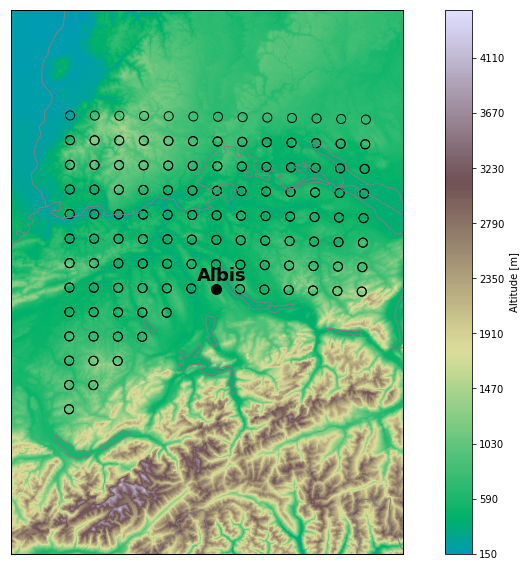

In [12]:
fig = createGDmap([1.,2.],mycoordlon, mycoordlat, londem, latdem)

In [13]:
#fig.savefig('/home/fvanden/Documents/EPFL/WeeklyReport/Week186_189/Images/HCmodelErr1500.png', dpi = 150, bbox_inches = 'tight')
#fig.savefig('/home/fvanden/Documents/EPFL/Articles/VerticalCones/Images/conegrid.png', dpi = 200, bbox_inches = 'tight')

fig.savefig('/home/fvanden/Documents/EPFL/Presentations/EGU_2019/Images/conegrid2.png', dpi = 200, bbox_inches = 'tight')

In [ ]:
fig, ax = plt.subplots()
plt.hist([Cmodelerr['error'], Smodelerr['error'], HCmodelerr['error']], label = ['C', 'S', 'HC'])

plt.legend()

In [ ]:
np.nanmean(Cmodelerr['error']), np.nanmean(Smodelerr['error']),np.nanmean(HCmodelerr['error'])